# Lab 12

In [4]:
library(tidyverse)
library(stringr)
library(modelr)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats


## Review/Explore

### Modeling - Setup

The lecture notes have done a thorough job of explaining the setup of a statistical model. But in general when we model data we are trying to predict some output `y`, based on the some inputs, `x`, with some estimated error, epsilon.

$$\underbrace{Y}_{\text{outcome}} = \underbrace{f}_{\text{model function}}(\underbrace{X}_{\text{explainer}}) + 
    \underbrace{\epsilon}_\text{noise}$$

Where f(x) could be any type of model we think fits well with the data (e.g. fitting a line to the data, fitting a parabola to the data, fitting a series of curved lines, etc.) and the 'noise' here refers to the fact that we know our model isn't going to perfectly fit the data.

### Categorical and continuous data
`modelr::sim3` has both continuous and categorical data:

In [2]:
sim3 %>% print

# A tibble: 120 x 5
      x1 x2      rep      y    sd
   <int> <fct> <int>  <dbl> <dbl>
 1     1 a         1 -0.571     2
 2     1 a         2  1.18      2
 3     1 a         3  2.24      2
 4     1 b         1  7.44      2
 5     1 b         2  8.52      2
 6     1 b         3  7.72      2
 7     1 c         1  6.51      2
 8     1 c         2  5.79      2
 9     1 c         3  6.07      2
10     1 d         1  2.11      2
# ... with 110 more rows


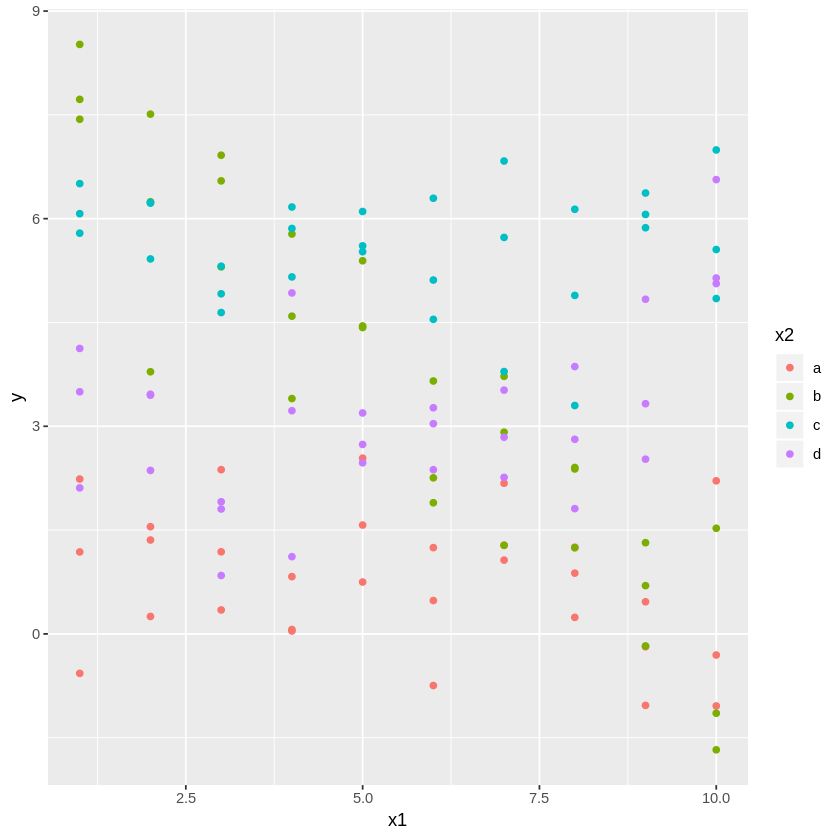

In [3]:
ggplot(sim3, aes(x1, y)) + 
  geom_point(aes(colour = x2))

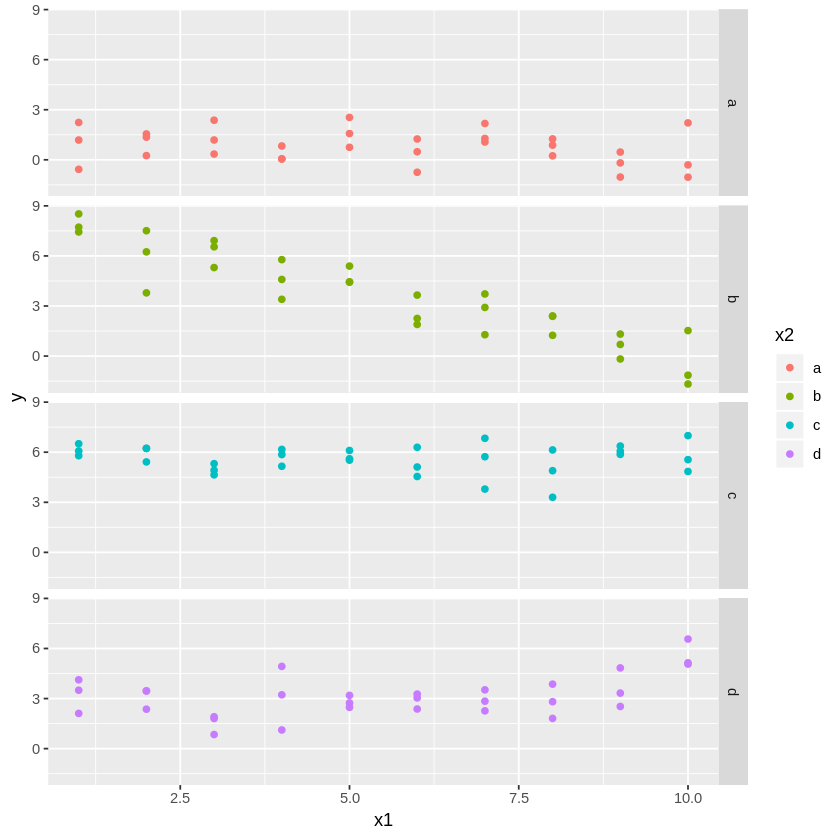

In [4]:
ggplot(sim3, aes(x1, y)) + geom_point(aes(colour = x2)) + facet_grid(x2 ~ .)

One way to model this data would be by adding both `x1` and `x2` to the model:

In [5]:
mod1 = lm(y ~ x1 + x2, data = sim3)
summary(mod1)


Call:
lm(formula = y ~ x1 + x2, data = sim3)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.4674 -0.8524 -0.0729  0.7886  4.3005 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.87167    0.38738   4.832 4.22e-06 ***
x1          -0.19674    0.04871  -4.039 9.72e-05 ***
x2b          2.88781    0.39571   7.298 4.07e-11 ***
x2c          4.80574    0.39571  12.145  < 2e-16 ***
x2d          2.35959    0.39571   5.963 2.79e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.533 on 115 degrees of freedom
Multiple R-squared:  0.5911,	Adjusted R-squared:  0.5768 
F-statistic: 41.55 on 4 and 115 DF,  p-value: < 2.2e-16


As before, this estimates a different intercept for each level of `x2`, but a common slope term.

Another option is to add an *interaction* between `x1` and `x2`:

In [6]:
mod2 = lm(y ~ x1 * x2, data = sim3)
summary(mod2)$coefficients

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),1.30124266,0.40399810,3.2209128,1.672947e-03
x1,-0.09302444,0.06511019,-1.4287233,1.558668e-01
x2b,7.06937991,0.57133959,12.3733416,1.091786e-22
x2c,4.43089525,0.57133959,7.7552743,4.406608e-12
x2d,0.83455115,0.57133959,1.4606920,1.468997e-01
x1:x2b,-0.76028528,0.09207971,-8.2568164,3.301095e-13
x1:x2c,0.06815284,0.09207971,0.7401505,4.607574e-01
x1:x2d,0.27727920,0.09207971,3.0112952,3.215600e-03


Now we get a number of new terms of the form `x1:x2<lvl>`. What do these represent? Let's again look at the model matrix:

In [7]:
m = sim3 %>% model_matrix(y ~ x1 * x2) %>% print

# A tibble: 120 x 8
   `(Intercept)`    x1   x2b   x2c   x2d `x1:x2b` `x1:x2c` `x1:x2d`
           <dbl> <dbl> <dbl> <dbl> <dbl>    <dbl>    <dbl>    <dbl>
 1             1     1     0     0     0        0        0        0
 2             1     1     0     0     0        0        0        0
 3             1     1     0     0     0        0        0        0
 4             1     1     1     0     0        1        0        0
 5             1     1     1     0     0        1        0        0
 6             1     1     1     0     0        1        0        0
 7             1     1     0     1     0        0        1        0
 8             1     1     0     1     0        0        1        0
 9             1     1     0     1     0        0        1        0
10             1     1     0     0     1        0        0        1
# ... with 110 more rows


The `x1:x2<lvl>` terms are again equal to 1 only if the corresponding observation had `x2==<lvl>`. For example, the first observation had `x2=='a'`, so the regression equation in this case is 

$$
\begin{align}
y &= a_0 + a_1 \texttt{x1} + a_2\texttt{x2b} + \cdots + a_5 \times \texttt{x1} \times \texttt{x1:x2b} + \cdots + a_7 \times \texttt{x1} \times \texttt{x1:x2d} \\
  &= a_0 + a_1 \texttt{x1} + a_2\times 0 + \cdots + a_5 \times 0 + \cdots + a_7 \times 0 \\
  &= a_0 + a_1 \texttt{x1}
\end{align}
$$

On the other hand, the 20th observation had

In [8]:
m[20,]

(Intercept),x1,x2b,x2c,x2d,x1:x2b,x1:x2c,x1:x2d
1,2,0,1,0,0,2,0


Repeating the same calculation as above, we get that the regression equation for observations with `x2=='c'` is equal to 

$$
y = (a_0 + a_3) + (a_1 + a_6)\times \texttt{x1}.
$$

We see that in this model, each different group of `x2` is allowed to have a different slope as well as intercept.

Let's compare `mod1` and `mod2`. To do this we will use the `gather_predictions` function, which takes a data grid and one or more models and adds a new row for each prediction for each model:

In [9]:
grid = sim3 %>% data_grid(x1, x2) %>% gather_predictions(mod1, mod2) %>% print

# A tibble: 80 x 4
   model    x1 x2     pred
   <chr> <int> <fct> <dbl>
 1 mod1      1 a      1.67
 2 mod1      1 b      4.56
 3 mod1      1 c      6.48
 4 mod1      1 d      4.03
 5 mod1      2 a      1.48
 6 mod1      2 b      4.37
 7 mod1      2 c      6.28
 8 mod1      2 d      3.84
 9 mod1      3 a      1.28
10 mod1      3 b      4.17
# ... with 70 more rows


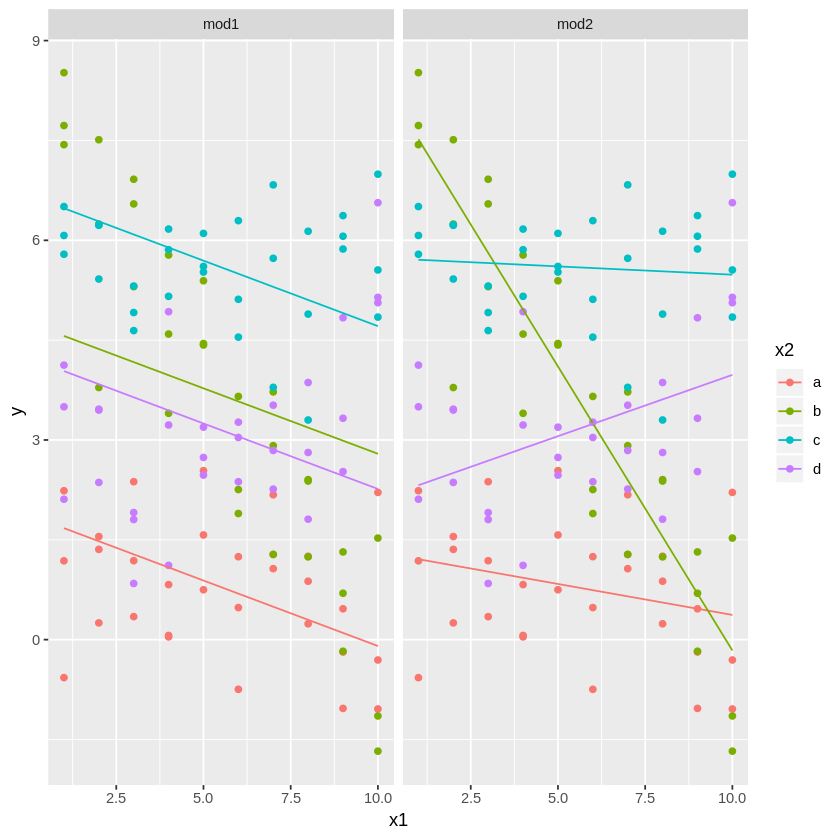

In [10]:
ggplot(sim3, aes(x1, y, color = x2)) + geom_point() + 
  geom_line(data = grid, aes(y = pred)) + 
  facet_grid( ~ model)

### Selecting between the models
How should we decide which model to use? We can make the same plots using `gather_residuals` instead of `gather_predicitons`:

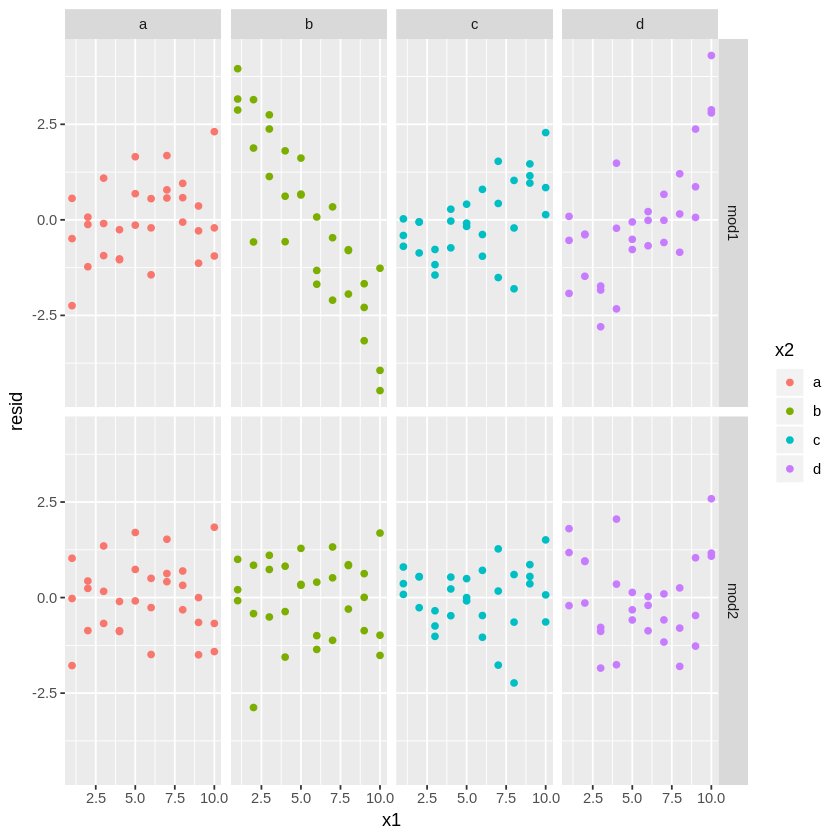

In [11]:
sim3 = sim3 %>% gather_residuals(mod1, mod2)

ggplot(sim3, aes(x1, resid, colour = x2)) + 
  geom_point() + 
  facet_grid(model ~ x2)

Which model's residuals look more random to you?

## Power Law Distribution

In network theory, the degree of an node in a network is the number of connections or edges that node has to other nodes. As we studied in the facebook data last homework, we can define nodes as facebook users and degrees as number of friends in facebook network.

The degree distribution is the probability distribution of these degrees over the whole network. Let's revisit 'fb.Rdata' to explore the degree distribution.

In [13]:
load("fb.RData")
fb_lst = unstack(fb, friend_id ~ user_id)
n_friends = map_int(fb_lst, length)

$breaks
  [1]    0   10   20   30   40   50   60   70   80   90  100  110  120  130  140
 [16]  150  160  170  180  190  200  210  220  230  240  250  260  270  280  290
 [31]  300  310  320  330  340  350  360  370  380  390  400  410  420  430  440
 [46]  450  460  470  480  490  500  510  520  530  540  550  560  570  580  590
 [61]  600  610  620  630  640  650  660  670  680  690  700  710  720  730  740
 [76]  750  760  770  780  790  800  810  820  830  840  850  860  870  880  890
 [91]  900  910  920  930  940  950  960  970  980  990 1000 1010 1020 1030 1040
[106] 1050

$counts
  [1] 1730  719  370  209  142  111   87   65   49   39   25   25   23   18   12
 [16]    9   13    2    6    1    1    1    1    0    0    0    0    0    0    0
 [31]    0    0    0    0    1    0    0    0    0    0    0    0    0    0    0
 [46]    0    0    0    0    0    0    0    0    0    1    0    0    0    0    0
 [61]    0    0    0    0    0    0    0    0    0    0    0    0    0    0    1


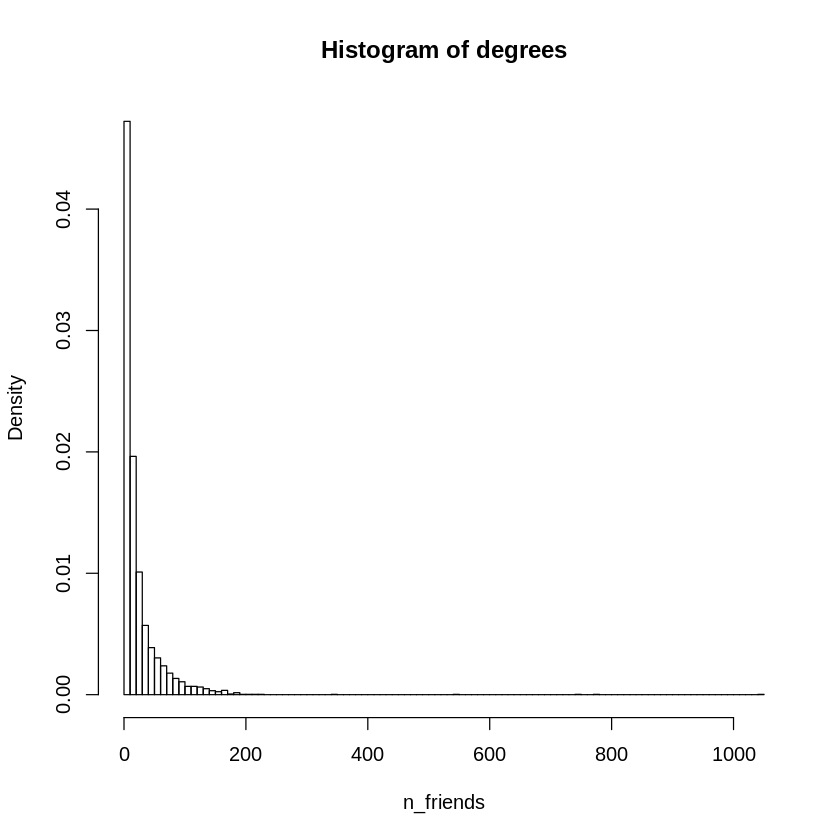

In [14]:
degree_dist = hist(n_friends, probability=TRUE, breaks=100, 
                    main='Histogram of degrees')
degree_dist

There are few examples in the real applications where we have a special property of the degree distribution. For example, if we look at the World Wide Web (WWW) network, the degree distribution follows the power law.

In statistics, a power law is a functional relationship between two quantities, where one quantity varies as a power of another. We can write this relationship as

$$ p(x) = C x^{-\alpha}$$
where $x$ is the number of degrees in our example. Then, we should see a straight line on a log-log plot as we have the following relationship

$$ \ln(p(x)) = c - \alpha \ln(x)$$

Let's look at the facebook dataset and see if we can describe this relationship.

In [173]:
degree_data = data.frame(prob=degree_dist$density, 
                         degree=degree_dist$breaks[-1])

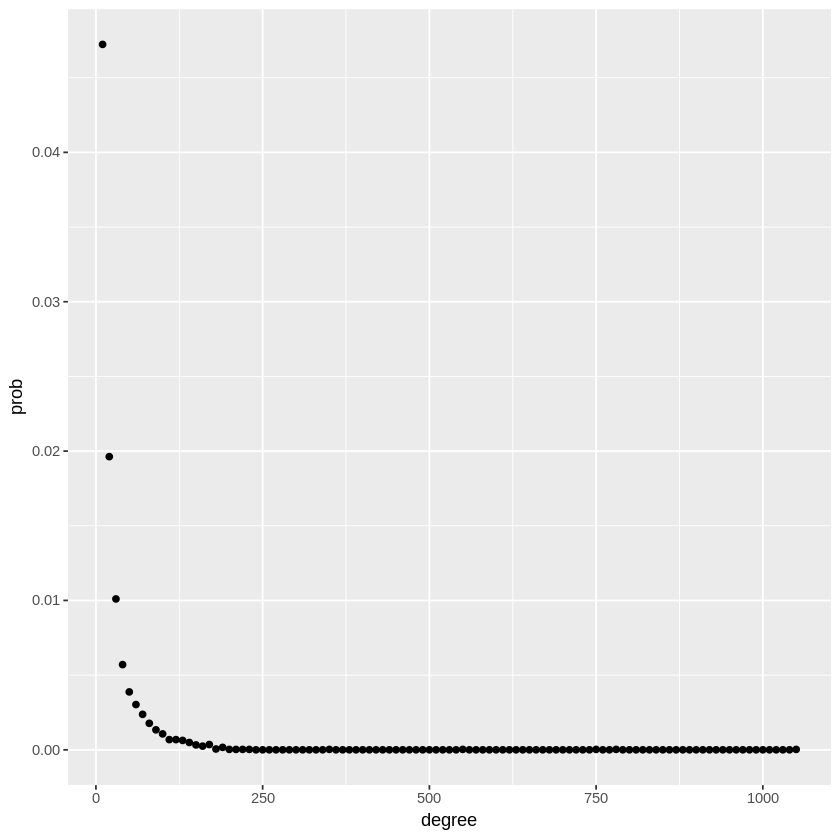

In [174]:
ggplot(data=degree_data, mapping=aes(x=degree, y=prob)) + geom_point()

As we mentioned before, we should see a linear relationship on a log-log scale.

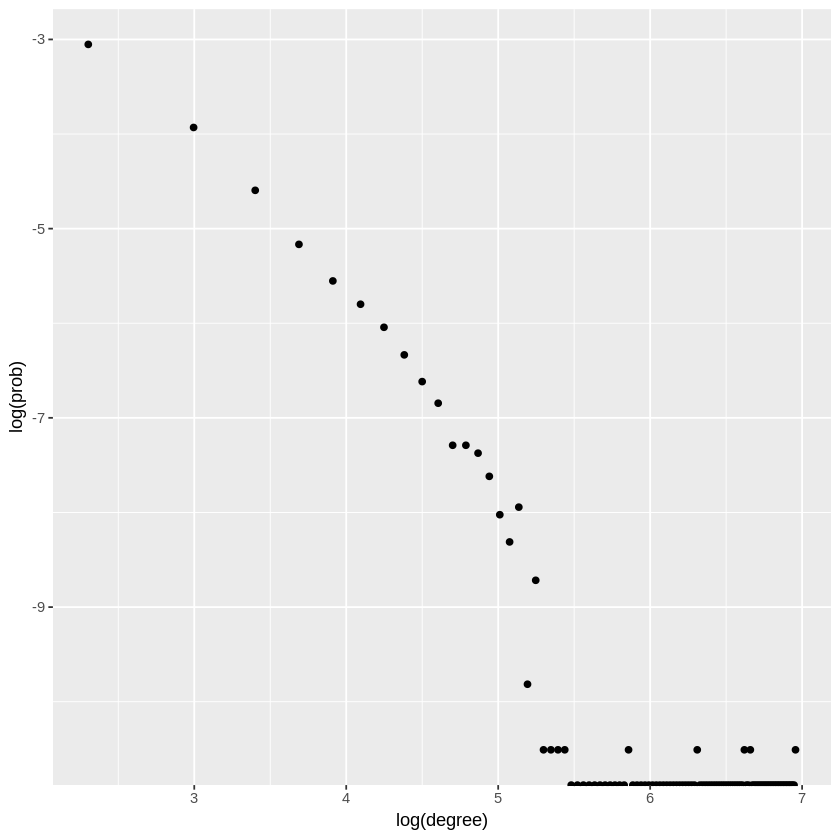

In [175]:
ggplot(data=degree_data, mapping=aes(x=log(degree), y=log(prob))) + geom_point()

In [176]:
# Take out the zero part
degree_data_clean = degree_data %>% filter(prob != 0)
mod1 = lm(log(prob) ~ log(degree), data = degree_data_clean)
summary(mod1)


Call:
lm(formula = log(prob) ~ log(degree), data = degree_data_clean)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.8098 -0.1703  0.3262  0.4778  1.4927 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.8535     0.7827   2.368   0.0256 *  
log(degree)  -1.9916     0.1564 -12.733 1.11e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8721 on 26 degrees of freedom
Multiple R-squared:  0.8618,	Adjusted R-squared:  0.8565 
F-statistic: 162.1 on 1 and 26 DF,  p-value: 1.114e-12


In [177]:
grid = degree_data %>% data_grid(degree) %>% gather_predictions(mod1) %>% print

# A tibble: 105 x 3
   model degree  pred
   <chr>  <dbl> <dbl>
 1 mod1      10 -2.73
 2 mod1      20 -4.11
 3 mod1      30 -4.92
 4 mod1      40 -5.49
 5 mod1      50 -5.94
 6 mod1      60 -6.30
 7 mod1      70 -6.61
 8 mod1      80 -6.87
 9 mod1      90 -7.11
10 mod1     100 -7.32
# ... with 95 more rows


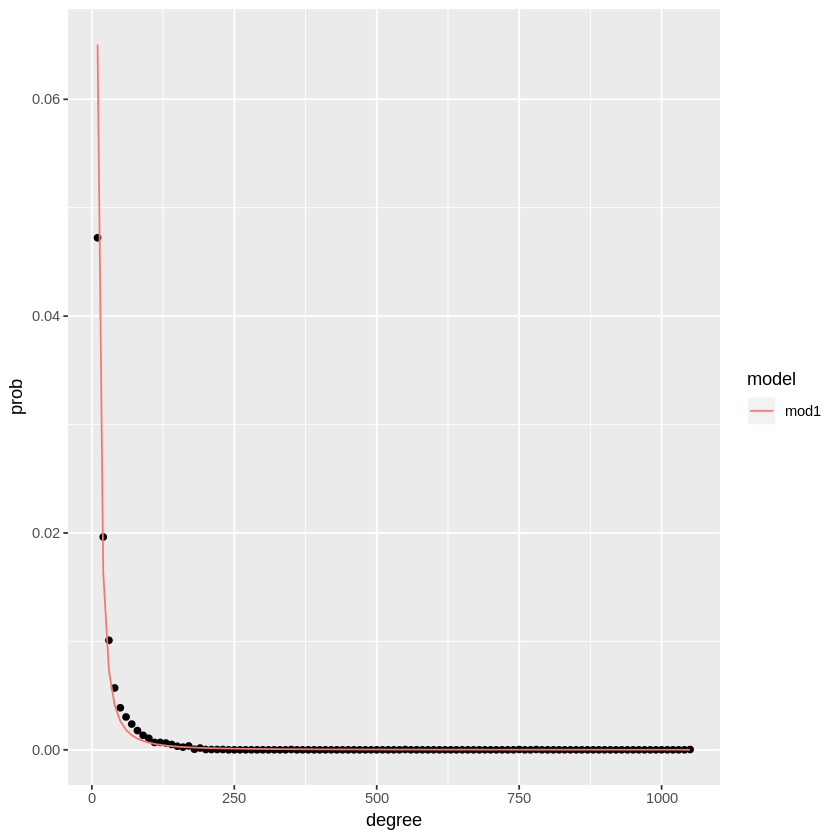

In [178]:
ggplot(degree_data, aes(x=degree, y=prob)) + geom_point() + 
  geom_line(data = grid, aes(y = exp(pred), color=model))

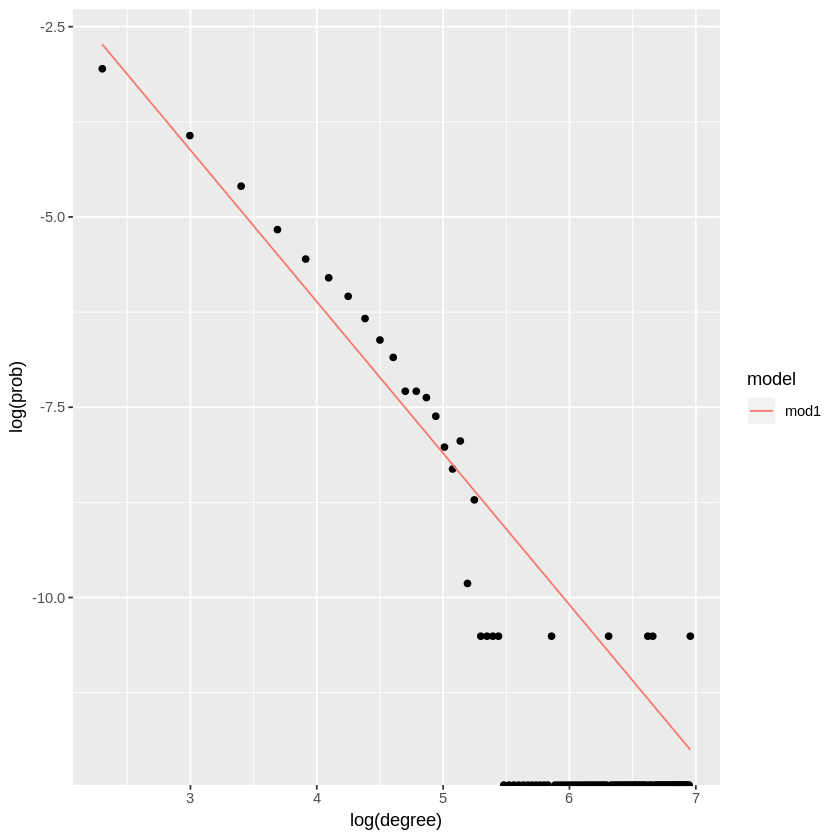

In [179]:
ggplot(degree_data, aes(x=log(degree), y=log(prob))) + geom_point() + 
  geom_line(data = grid, aes(y = pred, color=model))

Looking at this line, it doesn't look like we are correctly recovering the linear relationship between the log-transformed variables. Let's work through the same steps again with the flights dataset to see if we can fix this problem.

## Flights Dataset
We are going to look into the power distribution of the network of airports. First let's look at how the distribution of degrees and the corresponding networks look like. The illustration from [1] below gives a good intuition.

![Slides from [1]](degree_distribution.PNG)

We are going to repeat the above dataset analysis with the networks of airports.

In [5]:
airport_network = read.table('global-net.dat')

### 1. Calculate the data frame for n_airports with column names c('airport', 'n'). Where 'airport' column represents the available airports in the dataset and 'n' represents the corresponding number of airports that connects to 'airport'.

In [15]:
head(airport_network)

V1,V2
1,1198
1,2482
1198,1
1198,1054
1198,2482
1198,1970


In [16]:
n_airports = airport_network %>% group_by(V1) %>% 
        summarize(degree=n()) %>% select(airport=V1, degree)
head(n_airports)

airport,degree
1,2
2,6
4,3
5,11
6,10
7,6


### Using the same procedure as above, create model 1 that is calculated from regressing log(degree) on log(prob)

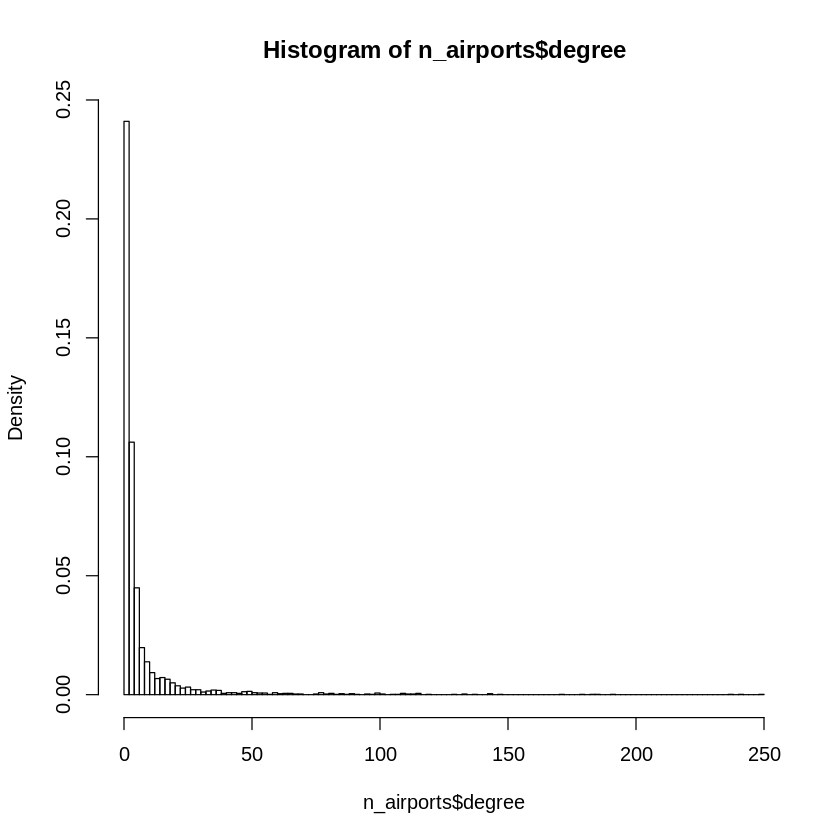

In [17]:
airport_dist = hist(n_airports$degree, probability=TRUE, breaks=100)

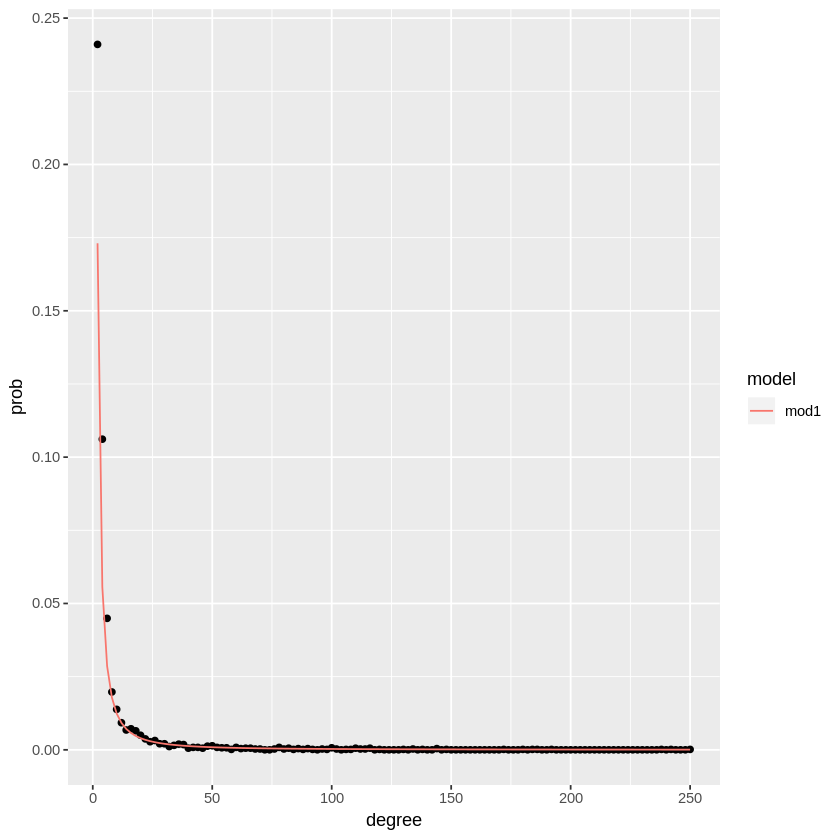

In [19]:
degree_data = data.frame(prob=airport_dist$density, degree=airport_dist$breaks[-1])

# Take out the zero part
degree_data_clean = degree_data %>% filter(prob != 0)
mod1 = lm(log(prob) ~ log(degree), data = degree_data_clean)

# Create a prediction column
grid = degree_data %>% data_grid(degree) %>% gather_predictions(mod1)

ggplot(degree_data, aes(x=degree, y=prob)) + geom_point() + 
  geom_line(data = grid, aes(y = exp(pred), color=model))

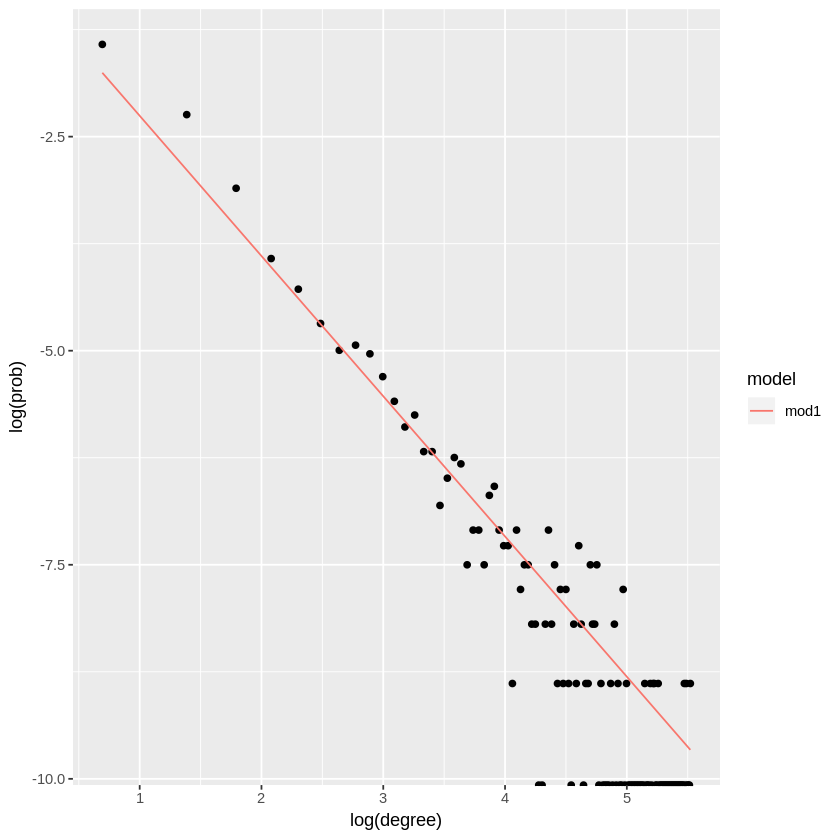

In [20]:
ggplot(degree_data, aes(x=log(degree), y=log(prob))) + geom_point() + 
  geom_line(data = grid, aes(y = pred, color=model))

There are some problems with directly applying the linear regression on the log-log transform data. Look at the following slides from [2]

![Slides from [1]](powerLaw1.png)

![Slides from [1]](powerLaw2.png)

![Slides from [1]](powerLaw3.png)

### Using the logarithmic binning, refit the linear regression on the log-log transform data and compare the two models

[1]    1    2    4    8   16   32   64  128  256  512 1024 2048

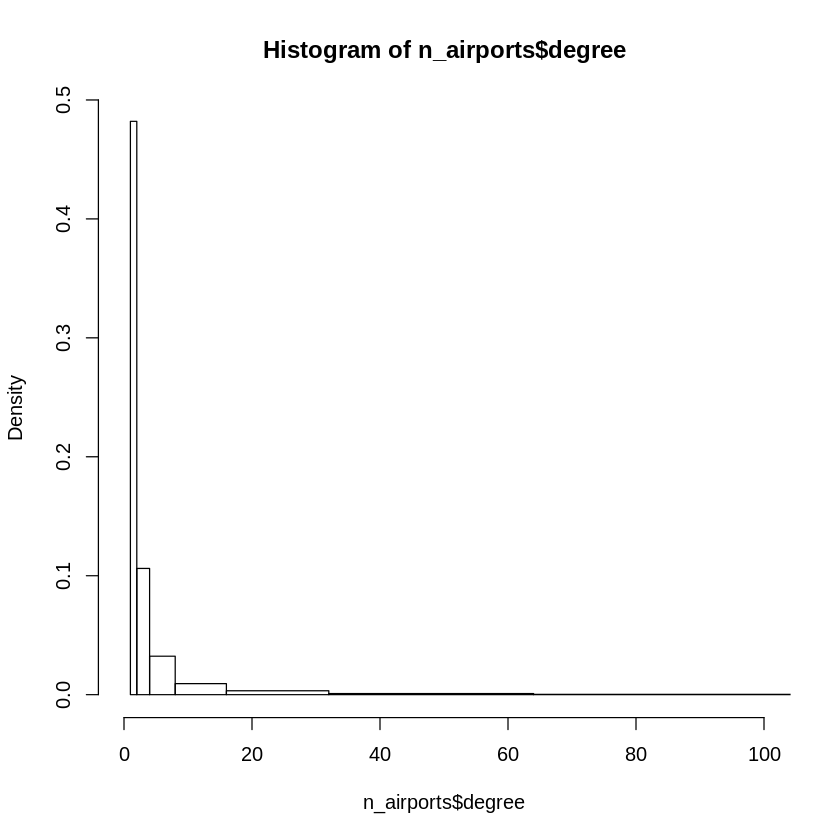

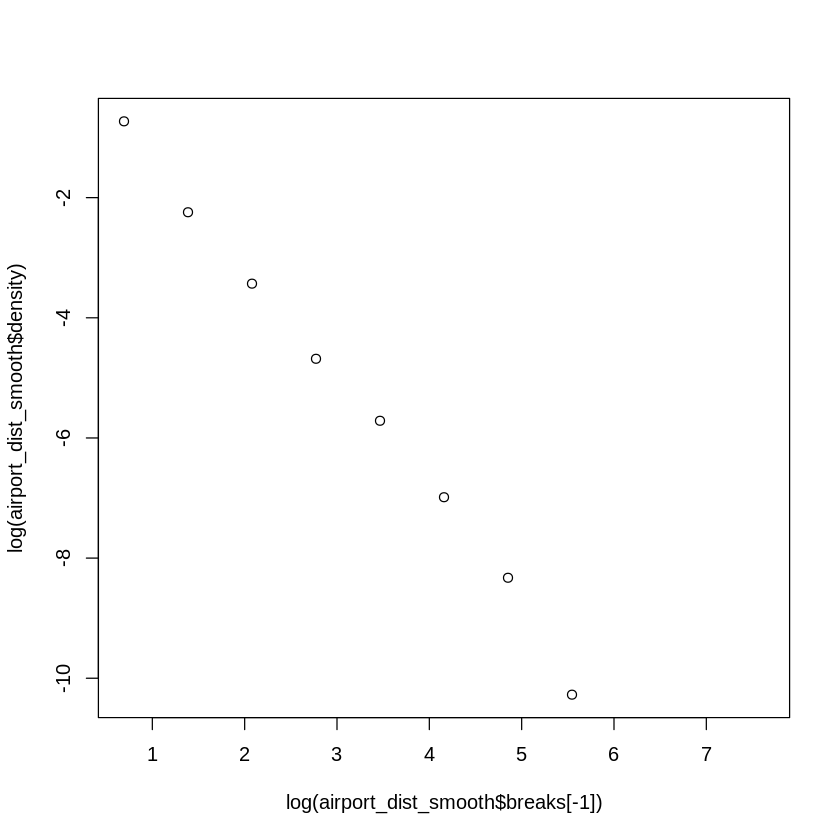

In [23]:
breaks = 2^(0:11)
breaks
airport_dist_smooth = hist(n_airports$degree, probability=TRUE, 
                    breaks=breaks,
                    xlim=c(0, 100))
plot(log(airport_dist_smooth$breaks[-1]), 
     log(airport_dist_smooth$density))

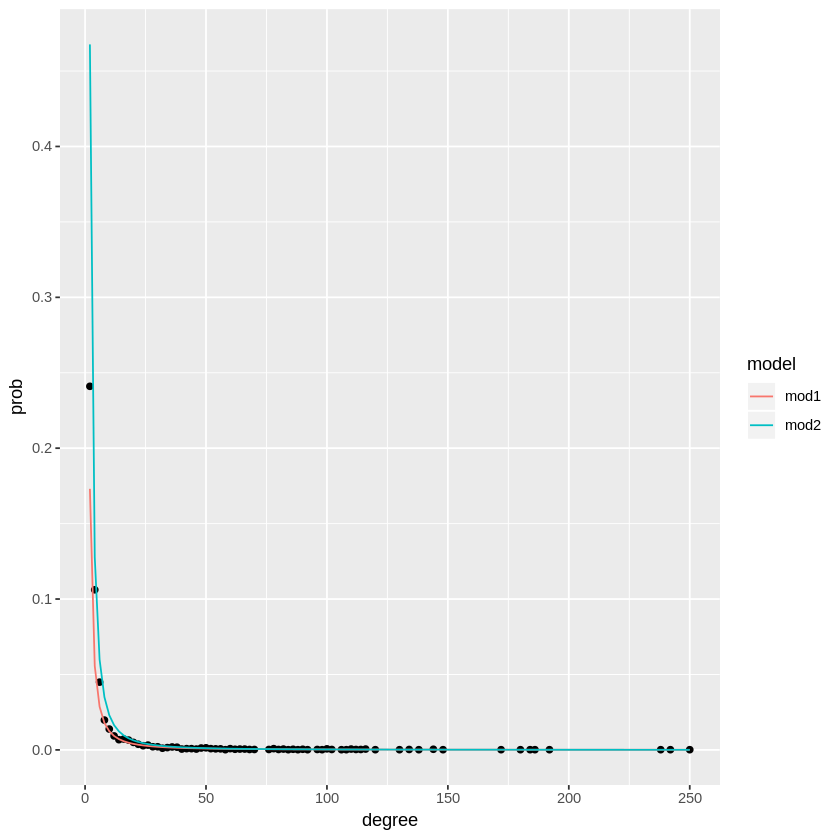

In [ ]:
degree_data_smooth = data.frame(prob=airport_dist_smooth$density, 
                                degree=airport_dist_smooth$breaks[-1])

# Take out the zero part
degree_data_smooth = degree_data_smooth %>% filter(prob != 0)
mod2 = lm(log(prob) ~ log(degree), data = degree_data_smooth)

# Create a prediction column
grid = degree_data %>% data_grid(degree) %>% gather_predictions(mod1, mod2)

ggplot(degree_data_clean, aes(x=degree, y=prob)) + geom_point() + 
  geom_line(data = grid, aes(y = exp(pred), color=model))

ggplot(degree_data_clean, aes(x=log(degree), y=log(prob))) + geom_point() + 
  geom_line(data = grid, aes(y = pred, color=model))

[1] Barabasi, A-L. Netowrk Science, the Scale-Free Property. [Link](http://barabasi.com/f/623.pdf)

[2] Eaton, Eric. Power-laws, scale free networks. [Link](https://cs.brynmawr.edu/Courses/cs380/spring2013/section02/slides/10_ScaleFreeNetworks.pdf)
